# Create data for shoreline detection
Load the images (X data) and shorelines (Y data), pre-process them to reduce the size to a manageable 320x480 and augment them if required.

In [2]:
# magic
%load_ext autoreload
%autoreload 2
%pdb 1
%matplotlib inline

Automatic pdb calling has been turned ON


In [3]:
# imports
from functions.data_preprocessing import load_images, augment_images_kp, mask_to_uv
from functions.data_preprocessing import load_train_test_imagedata, save_train_test_imagedata

import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np

import os

import torch

from sklearn.model_selection import train_test_split

import imgaug as ia
import imgaug.augmenters as iaa

from ipywidgets import interact, fixed, IntSlider, FloatSlider, interact_manual

## Import the data
1. Read in matlab database structure containing a list of arrays of UV (pixel) coordinates in the "UV" field and a list of image names in the "name" field. The code will read these images and match them with the associated shoreline pixels given by UV.
1. Import the images.
3. Downscale (to smaller fixed image size) 
4. Convert the UV (U - width and V - heights) co-ordinates to an image mask.

In [4]:
# Specify settings
imSize = (320,480) # specify the target image size (height, width)
imDir = './raw_data/{}' # specify the directory with image data
extractNum = 50

# Load the UV data and get image names
rawShlData = sio.loadmat('./raw_data/allSitesShorelineDatabase.mat', struct_as_record=False, squeeze_me=True)['fullDB']
rawUVData = [_.UV for _ in rawShlData]
imgNames = [_.name for _ in rawShlData]

imgPaths = [imDir.format(_) for _ in imgNames]

takeInds = np.random.choice(imgPaths.__len__()-1,size=extractNum,replace=False)

loadImPaths = [_ for ii, _ in enumerate(imgPaths) if ii in takeInds]
loadEdgeCoords = [_ for ii, _ in enumerate(rawUVData) if ii in takeInds]
imData, uvData = load_images(loadImPaths,imSize,edgeCoords=loadEdgeCoords)

print(imData.shape)

Loading 50 images...
[====================] 100% - Processing: 50 of 50.Done!
(50, 320, 480, 3)


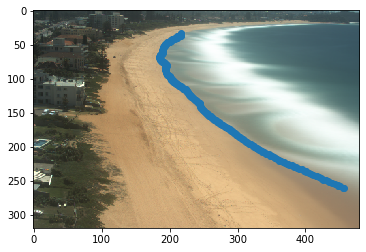

In [19]:
# check the images
ii = 30
plt.imshow(imData[ii])
plt.scatter(mask_to_uv(uvData[ii])[0],mask_to_uv(uvData[ii])[1])
plt.show()

In [11]:
# train test split
nanClean = np.unique(np.where(np.isnan(uvData))[0])
mask = np.ones(uvData.shape[0], dtype=bool)
mask[nanClean] = False
uvData = uvData[mask,...]
imData = imData[mask,...]

testSize = 0.2
train_X, test_X, train_Y, test_Y = train_test_split(imData, uvData,
                                                    test_size = testSize,
                                                    random_state = 2019)
print('Train data - X: {}, Y: {}'.format(train_X.shape,train_Y.shape))
print('Test data - X: {}, Y: {}'.format(test_X.shape,test_Y.shape))

Train data - X: (40, 320, 480, 3), Y: (40, 320, 480)
Test data - X: (10, 320, 480, 3), Y: (10, 320, 480)


## Augment the data
Augment the data to produce a robust training set. Uses the package [imaug](https://github.com/aleju/imgaug) to ensure the shoreline masks are transformed appropriately into the new augmented images.

In [12]:
# augment the data if requested
augmentBool = False

# Settings
if augmentBool:
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)

    seq = iaa.Sequential(
        [
            iaa.Fliplr(0.5), # horizontally flip 50% of all images
            iaa.Flipud(0.5), # vertically flip 20% of all images
    #         sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1))),
            # crop images by -5% to 10% of their height/width
            sometimes(iaa.CropAndPad(
                percent=(-0.05, 0.1),
                pad_mode='constant',
                pad_cval=(0, 255)
            )),
            sometimes(iaa.Affine(
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
                translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
                rotate=(-45, 45), # rotate by -45 to +45 degrees
                #shear=(-16, 16), # shear by -16 to +16 degrees
                order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                #mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
            )),
            ],
        random_order=True
        )
else:
    seq = iaa.Sequential(
        [],
        random_order=True
        )

aug_X, aug_Y = augment_images_kp(train_X,train_Y, seq)
    
# final changes to the data
if aug_X.max() > 1:
    aug_X = aug_X/255
    train_X = train_X/255
    test_X = test_X/255

Performing augmentation...
Transforming Y to mask...
[====================] 100% - Processing: 40 of 40.
Done!


In [ ]:
# check the data augmentation
def aug_plot(ii,aug_X,aug_Y,train_X,train_Y):
    fig = plt.figure(figsize=(14,8))
    ax1 = fig.add_subplot(121)
    ax1.imshow(aug_X[ii,...])
    ax1.scatter(mask_to_uv(aug_Y[ii,...])[0],mask_to_uv(aug_Y[ii,...])[1],s=5,color='coral')
    ax1.set_title('Augmented image')
    ax2 = fig.add_subplot(122)
    ax2.imshow(train_X[ii,...])
    ax2.scatter(np.where(train_Y[ii,...])[1],np.where(train_Y[ii,...])[0],s=5,color='coral')
    ax2.set_title('Original image')
    plt.show()

interact(aug_plot,
         ii=IntSlider(
             value=0,
             min=0,
             step=1,
             max=aug_Y.shape[0]-1,
             continuous_update=False,
         ),
         aug_X=fixed(aug_X),
         aug_Y=fixed(aug_Y),
         train_X=fixed(train_X),
         train_Y=fixed(train_Y),
        )

In [9]:
# save the images and make them ready for training
basePath = './data/'
partition, labels = save_train_test_imagedata(basePath, aug_X, aug_Y, test_X, test_Y)
del aug_X, aug_Y, train_X, train_Y, test_X, test_Y

Loading 40 training images...
[====================] 100% - Processing: 40 of 40.
Loading 10 test images...
[====================] 100% - Processing: 10 of 10.